In [ ]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the current directory if __file__ is not available
current_dir = os.getcwd()  # Gets the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))  # Moves one level up

# Add the parent directory to the Python path
sys.path.insert(0, parent_dir)
from save_and_compare_results import *


In [ ]:
# Define the path to the parent directory
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Move one level up

X = pd.read_pickle(os.path.join(data_dir, "data/X_matrix_proteins.pkl"))
Y = pd.read_pickle(os.path.join(data_dir, "data/Y_matrix_proteins.pkl"))

In [19]:
# Preprocess the data
X = X.drop(columns=["Yeast_ID"]).fillna(0)
Y = Y.drop(columns=["Yeast_ID"]).fillna(Y.drop(columns=["Yeast_ID"]).mean())

In [20]:
# Initialize the model
xgb = XGBRegressor(random_state=42, objective="reg:squarederror", verbosity=0)

# Define the hyperparameter distributions
param_distributions = {
    "learning_rate": uniform(0.01, 0.2),  # Range of values
    "n_estimators": randint(50, 300),     # Random number of boosting rounds
    "max_depth": randint(3, 10),          # Random max depth
    "subsample": uniform(0.6, 0.4),       # Range 0.6–1.0
    "colsample_bytree": uniform(0.6, 0.4),# Range 0.6–1.0
    "reg_alpha": uniform(0, 1),           # Range for L1
    "reg_lambda": uniform(1, 5)           # Range for L2
}

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=100,  # Test only 100 combinations
    scoring="r2",
    cv=4,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [21]:
print("Training the XGBoost model with hyperparameter tuning...")
random_search.fit(X, Y.values.ravel())

Training the XGBoost model with hyperparameter tuning...
Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV] END colsample_bytree=0.749816047538945, learning_rate=0.20014286128198325, max_depth=5, n_estimators=121, reg_alpha=0.5986584841970366, reg_lambda=1.7800932022121825, subsample=0.662397808134481; total time=  21.0s
[CV] END colsample_bytree=0.749816047538945, learning_rate=0.20014286128198325, max_depth=5, n_estimators=121, reg_alpha=0.5986584841970366, reg_lambda=1.7800932022121825, subsample=0.662397808134481; total time=  21.1s
[CV] END colsample_bytree=0.749816047538945, learning_rate=0.20014286128198325, max_depth=5, n_estimators=121, reg_alpha=0.5986584841970366, reg_lambda=1.7800932022121825, subsample=0.662397808134481; total time=  21.3s
[CV] END colsample_bytree=0.749816047538945, learning_rate=0.20014286128198325, max_depth=5, n_estimators=121, reg_alpha=0.5986584841970366, reg_lambda=1.7800932022121825, subsample=0.662397808134481; total time=  21.7s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.8010716092915446, learning_rate=0.02029575024999787, max_depth=7, n_estimators=273, reg_alpha=0.9082658859666537, reg_lambda=2.197809453334862, subsample=0.6579579488364892; total time=  42.9s
[CV] END colsample_bytree=0.8010716092915446, learning_rate=0.02029575024999787, max_depth=7, n_estimators=273, reg_alpha=0.9082658859666537, reg_lambda=2.197809453334862, subsample=0.6579579488364892; total time=  42.5s
[CV] END colsample_bytree=0.8010716092915446, learning_rate=0.02029575024999787, max_depth=7, n_estimators=273, reg_alpha=0.9082658859666537, reg_lambda=2.197809453334862, subsample=0.6579579488364892; total time=  42.6s
[CV] END colsample_bytree=0.8010716092915446, learning_rate=0.02029575024999787, max_depth=7, n_estimators=273, reg_alpha=0.9082658859666537, reg_lambda=2.197809453334862, subsample=0.6579579488364892; total time=  42.8s
[CV] END colsample_bytree=0.6602870175861718, learning_rate=0.11163975534814373, max_depth=7, n_estimators=52, reg_a

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff71803ff40>,
                     

In [22]:
best_xgb = random_search.best_estimator_
best_params = random_search.best_params_
print("\nBest hyperparameters:", best_params)


Best hyperparameters: {'colsample_bytree': 0.9208787923016158, 'learning_rate': 0.024910128735954166, 'max_depth': 9, 'n_estimators': 58, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 1.993578407670862, 'subsample': 0.602208846849441}


In [23]:
y_pred = best_xgb.predict(X)
r2 = r2_score(Y, y_pred)
mse = mean_squared_error(Y, y_pred)
print(f"\nR² Score: {r2:.4f}, Mean Squared Error: {mse:.4f}")


R² Score: 0.5316, Mean Squared Error: 0.0235


with numbers :  
Best hyperparameters: {'colsample_bytree': 0.9208787923016158, 'learning_rate': 0.024910128735954166, 'max_depth': 9, 'n_estimators': 58, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 1.993578407670862, 'subsample': 0.602208846849441}  
R² Score: 0.5358, Mean Squared Error: 0.0233

with binary :  
Best hyperparameters: {'colsample_bytree': 0.9208787923016158, 'learning_rate': 0.024910128735954166, 'max_depth': 9, 'n_estimators': 58, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 1.993578407670862, 'subsample': 0.602208846849441}  
R² Score: 0.5316, Mean Squared Error: 0.0235

# Model features importance

In [24]:
# Save feature importance from XBG
print("Saving XBG feature importances...")
save_feature_importance(
    features=X.columns,
    importance_scores=best_xgb.feature_importances_,
    method="model",
    model_name="XGBoost"
)

# Display and plot the top 10 features
print("Displaying top 10 features...")
feature_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

top_features = feature_importances_df.head(10)

print("\nTop 10 Features Impacting YPD Doubling Time:")
print(top_features)


Saving XBG feature importances...
Feature importance saved to results/XGBoost_model_importance.csv
Displaying top 10 features...

Top 10 Features Impacting YPD Doubling Time:
            Feature  Importance
953         YDL191W    0.010930
4238        YLR260W    0.009176
4843        YMR221C    0.007868
1760        YER071C    0.007837
5144        YNL173C    0.007653
2583        YGR256W    0.007428
8085  YER046W-A_CNV    0.007394
1707        YER029C    0.006973
1804        YER103W    0.006763
4884        YMR259C    0.006702


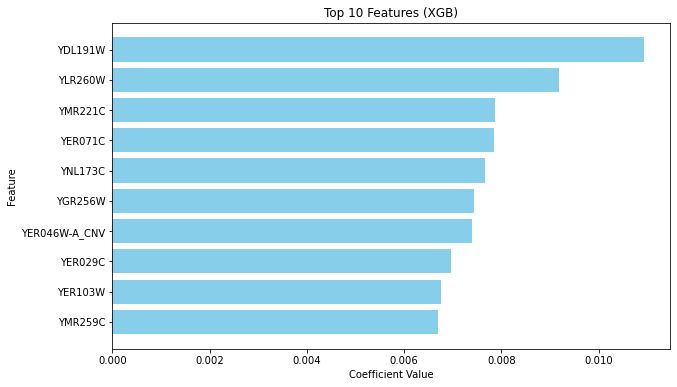

In [25]:
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 10 Features (XGB)")
plt.gca().invert_yaxis()
plt.show()

# SHAP features importance

Calculating SHAP values...
Saving SHAP importance scores for XGBoost...
Feature importance saved to results/XGBoost_SHAP_importance.csv
Generating SHAP plots...


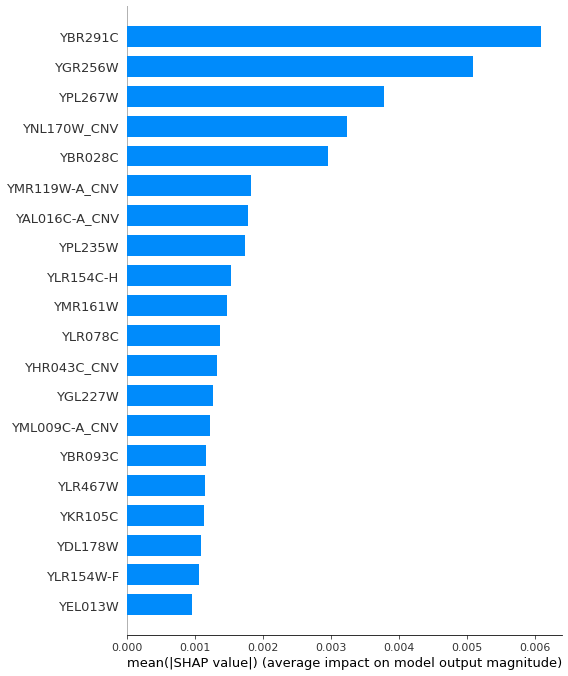

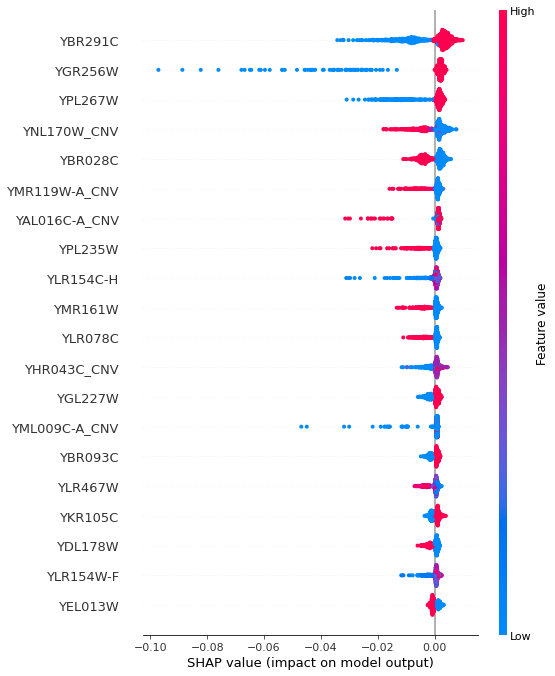

In [26]:
# SHAP analysis
print("Calculating SHAP values...")
explainer = shap.Explainer(best_xgb, X)
shap_values = explainer(X)
shap_mean_importance = np.abs(shap_values.values).mean(axis=0)

# Save SHAP importance scores
print("Saving SHAP importance scores for XGBoost...")
save_feature_importance(
    features=X.columns,
    importance_scores=shap_mean_importance,
    method="SHAP",
    model_name="XGBoost"
)

# %%
# SHAP plots
print("Generating SHAP plots...")
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)